In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt


In [2]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


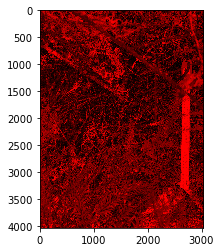

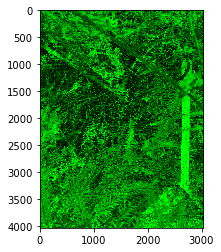

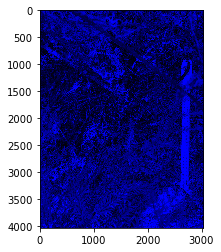

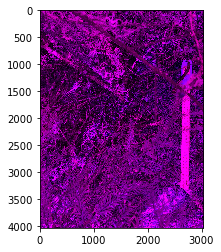

In [5]:
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True, help="path to the input image")
# ap.add_argument("-w", "--width", type=float, required=True, help="width of the left-most object in the image (in inches)")
# args = vars(ap.parse_args())
# load the image, convert it to grayscale, and blur it slightly
# image = cv2.imread(args["image"])
# image = cv2.imread('ground-fuel-example3.jpg')
# image = cv2.imread('19-PM42253411-4Da.jpg')
image = cv2.imread('19-PM42123427-2Df.jpg')
dx,dy,dc = image.shape

red_channel = image.copy()
red_channel[:,:,1] = 0
red_channel[:,:,2] = 0

plt.imshow(red_channel)
plt.show()

green_channel = image.copy()
green_channel[:,:,0] = 0
green_channel[:,:,2] = 0

plt.imshow(green_channel)
plt.show()

blue_channel = image.copy()
blue_channel[:,:,0] = 0
blue_channel[:,:,1] = 0

plt.imshow(blue_channel)
plt.show()

no_green = image.copy()
no_green[:,:,1] = 0

plt.imshow(no_green)
plt.show()

In [21]:
#invert green image to getrid of white part
green_channel = cv2.cvtColor(green_channel, cv2.COLOR_RGB2GRAY)
green_channel = cv2.GaussianBlur(green_channel, (7, 7), cv2.THRESH_BINARY)
_,invert_threshold_green = cv2.threshold(green_channel, 40, 255,1)

plt.imshow(invert_threshold_green)
plt.show()

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


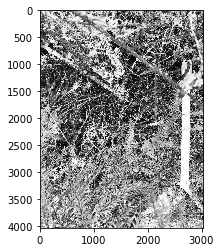

In [4]:
#chose the image channels for after processing
image = red_channel
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), cv2.THRESH_BINARY)
gray = cv2.equalizeHist(gray)
plt.imshow(gray,'gray')
plt.show()

TypeError: Image data of dtype object cannot be converted to float

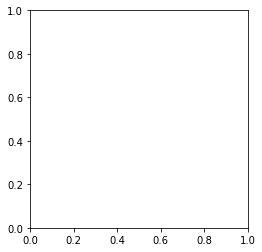

In [16]:
# perform threshold detection, then perform a dilation + erosion to
# close gaps in between object edges
ret,thresh_img = cv2.threshold(gray, 40, 255,0)
plt.imshow(thresh_img,'gray')
plt.show()

thresh_img = cv2.erode(thresh_img, None, iterations=1)
plt.imshow(thresh_img,'gray')
plt.show()

thresh_img = cv2.dilate(thresh_img, None, iterations=1)
plt.imshow(thresh_img,'gray')
plt.show()

out = thresh_img

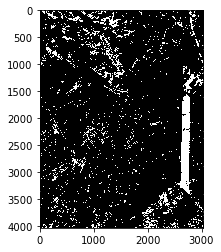

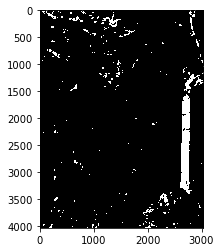

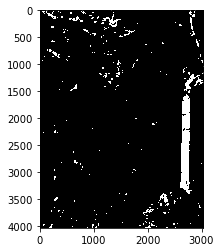

In [15]:
# perform threshold detection, then perform amorephology open and close

ret,img = cv2.threshold(gray, 230, 255,0)
# img = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(img,'gray')
plt.show()

img_bw = img.copy()

se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

mask = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, se1)
out = img * mask
plt.imshow(out,'gray')
plt.show()

# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se2)
# out = img * mask
plt.imshow(out,'gray')
plt.show()
# mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se2)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

In [7]:
# find contours in the edge map
# cnts = cv2.findContours(out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cv2.findContours(out.copy(), cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
# (cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None
print(len(cnts))


269


21


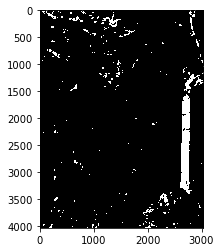

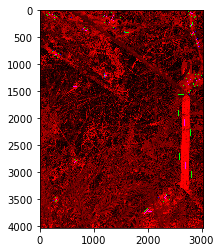

In [11]:
counter = 0
orig = image.copy()
# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 2500:
        continue
    # compute the rotated bounding box of the contour
    counter = counter +1

    box = cv2.minAreaRect(c)
#     print(box)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
#     # order the points in the contour such that they appear
#     # in top-left, top-right, bottom-right, and bottom-left
#     # order, then draw the outline of the rotated bounding
#     # box
#     box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
        (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
        (255, 0, 255), 2)

    
    
print(counter)
plt.imshow(out,'gray')
plt.show()

plt.imshow(orig)
plt.show()

30


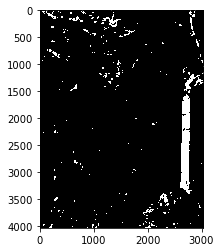

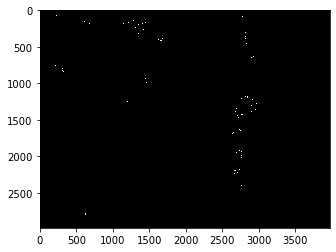

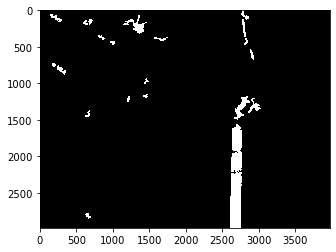

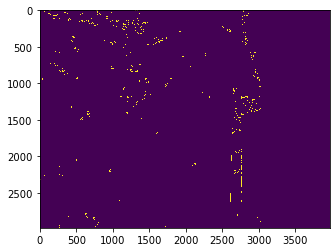

In [9]:
test = np.zeros((dx, dy),dtype=np.uint8)
filled = np.zeros((dx, dy),dtype=np.uint8)
counter = 0
orig = test
# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 2000:
        continue
    counter = counter +1

    orig = cv2.drawContours(orig, c, -1, (255, 255,255), 2)
    cv2.fillPoly(filled, pts = [c], color=(255,255,255)) 
  
print(counter)

plt.imshow(out,'gray')
plt.show()

plt.imshow(orig,'gray')
plt.show()

plt.imshow(filled,'gray')
plt.show()

test = np.zeros((2977, 3969),dtype=np.uint8)
test = cv2.drawContours(test, cnts, -1, (255, 255,255), 2)
plt.imshow(test)
plt.show()

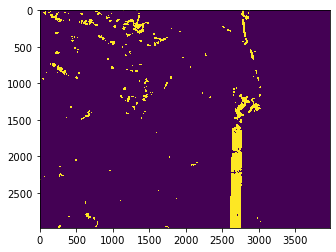

In [10]:
test = np.zeros( (dx, dy) ) # create a single channel 200x200 pixel black image 
cv2.fillPoly(test, pts = cnts, color=(255,255,255))
plt.imshow(test)
plt.show()